# Zero Day Intrusion Detection Using IoT Devices Threats Dataset
In this notebook, we will attempt to make a machine learning model to detect attacks on IoT devices. The dataset can be accessed [here](https://www.kaggle.com/datasets/mkashifn/nbaiot-dataset).

In this notebook, we will attempt to make a deep learning model using Artificial Neural Networks (ANNs) to detect cyber attacks in IoT Devices. The devices are mentioned below:
- Security Cameras
- Doorbell System
- Webcams
- And so on

Briefly describing, threats are of 3 types, i.e., benign, gafgyt and mirai attacks. We'll attempt to make deep learning model that can classify threats in one of these classes.

## Importing Libraries

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense, Flatten, Conv2D, BatchNormalization
from keras.callbacks import EarlyStopping

In [ ]:
print('TF Version: %s' % str(tf.__version__))
print('Keras Version: %s' % str(keras.__version__))

TF Version: 2.8.2
Keras Version: 2.8.0


In [ ]:
!nvidia-smi

Sat Jul 23 16:30:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P8     9W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Loading Data
The first step is to load data from a .csv file available to us already.

In [ ]:
def load_dataset_from_file(filename):
  '''
  A function to load all data in memory.
  '''
  data = pd.read_csv(filename + '.csv')
  return data

In [ ]:
# loading dataset from .csv files
%%time
benign_packets = load_dataset_from_file('/content/drive/MyDrive/Data/Attacks PT_737E_SC/benign_traffic_provision_PT_737E_SC')
gafgyt_combo = load_dataset_from_file('/content/drive/MyDrive/Data/Attacks PT_737E_SC/gafgyt_combo')
gafgyt_junk = load_dataset_from_file('/content/drive/MyDrive/Data/Attacks PT_737E_SC/gafgyt_junk')
gafgyt_scan = load_dataset_from_file('/content/drive/MyDrive/Data/Attacks PT_737E_SC/gafgyt_scan')
gafgyt_tcp = load_dataset_from_file('/content/drive/MyDrive/Data/Attacks PT_737E_SC/gafgyt_tcp')
gafgyt_udp = load_dataset_from_file('/content/drive/MyDrive/Data/Attacks PT_737E_SC/gafgyt_udp')
mirai_ack = load_dataset_from_file('/content/drive/MyDrive/Data/Attacks PT_737E_SC/ack')

CPU times: user 6.22 s, sys: 328 ms, total: 6.55 s
Wall time: 6.94 s


The dataset files have been loaded into memory. It contains:
- Benign Packets Recieved by IoT Device
- Gafgyt Attacks Received by IoT Device
- Mirai Attacks Receieved Bt IoT Device

All these threats are received by **Provision PT 737E Security Camera**. In original dataset, there are total 9 devices that received IoT Botnet attacks, but keeping in view limited resources, we'll detect 6 different types of attacks (1 benign, 6 attacks) on above-mentioned device. 

We'll be using a fraction of each of the files that we have loaded above for the sake of better accuracy and faster computation.

In [ ]:
# taking a fraction of dataset
%%time
benign_packets = benign_packets.sample(frac=0.5, replace=False)
gafgyt_combo = gafgyt_combo.sample(frac=0.5, replace=False)
gafgyt_junk = gafgyt_junk.sample(frac=0.5, replace=False)
gafgyt_scan = gafgyt_scan.sample(frac=0.5, replace=False)
gafgyt_tcp = gafgyt_tcp.sample(frac=0.5, replace=False)
gafgyt_udp = gafgyt_udp.sample(frac=0.5, replace=False)
mirai_ack = mirai_ack.sample(frac=0.5, replace=False)

CPU times: user 169 ms, sys: 33.5 ms, total: 202 ms
Wall time: 200 ms


## Some Data Analysis
For the sake of understanding, we'll analyze the data to make comprehension about dataset features and training samples.

In [ ]:
benign_packets.head(2)

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
30932,1.000000,60.000000,0.00000,1.000000,60.000000,0.000000,1.000000,60.000012,0.007428,14.109407,...,4.550000e-13,0.000000,0.000000,1.705672,60.000000,9.540000e-07,60.000000,9.090000e-13,0.000000,0.000000
8820,1.000039,89.999429,0.01714,1.004603,89.931789,2.041681,1.549504,84.691487,131.074042,7.116549,...,1.853889e+02,-5.914276,-0.435789,6.257896,84.824129,1.133519e+01,104.164714,1.284884e+02,0.764899,0.080305


In [ ]:
gafgyt_combo.head(4)

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
15272,166.958522,74.193562,99.930377,274.310122,74.796442,531.618226,804.036089,76.290712,1709.085052,6507.134988,...,0.000000e+00,0.0,0.0,1.000000,74.0,0.0,74.000000,0.0,0.0,0.0
6794,156.798749,74.016314,0.391267,265.582248,74.026320,0.631032,819.113709,74.039378,1.582219,5184.194140,...,0.000000e+00,0.0,0.0,1.000000,74.0,0.0,74.000000,0.0,0.0,0.0
31838,128.327212,74.005645,0.135894,233.715950,74.013808,0.347523,761.613898,74.043740,4.910537,7856.838770,...,0.000000e+00,0.0,0.0,1.687391,74.0,0.0,95.268043,0.0,0.0,0.0
42468,150.975486,74.015480,0.372623,254.520991,74.026578,0.798208,705.554140,74.092168,14.017015,6520.238410,...,9.094947e-13,0.0,0.0,1.679363,74.0,0.0,95.268043,0.0,0.0,0.0


In [ ]:
gafgyt_junk.head(4)

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
8157,171.173037,74.071334,1.706924,279.361598,74.063818,1.527557,834.497433,74.049729,1.514254,5305.148668,...,0.0,0.0,0.0,1.00000,74.0,0.000000e+00,74.000000,0.000000e+00,0.0,0.0
7974,136.764577,74.006537,0.156847,247.552071,74.015033,0.360567,808.052463,74.030925,1.145158,5222.480625,...,0.0,0.0,0.0,1.00000,74.0,0.000000e+00,74.000000,0.000000e+00,0.0,0.0
28991,217.201009,74.055318,1.541764,337.310785,74.047134,2.505683,904.193842,74.273483,197.313954,7537.056250,...,0.0,0.0,0.0,1.69553,74.0,9.536743e-07,95.268043,9.094947e-13,0.0,0.0
27454,179.080605,74.047931,30.233909,293.624645,74.309134,240.588649,844.662750,75.519355,1227.919667,7304.506296,...,0.0,0.0,0.0,1.00000,74.0,0.000000e+00,74.000000,0.000000e+00,0.0,0.0


In [ ]:
benign_packets.shape

(31077, 115)

In [ ]:
gafgyt_combo.columns

Index(['MI_dir_L5_weight', 'MI_dir_L5_mean', 'MI_dir_L5_variance',
       'MI_dir_L3_weight', 'MI_dir_L3_mean', 'MI_dir_L3_variance',
       'MI_dir_L1_weight', 'MI_dir_L1_mean', 'MI_dir_L1_variance',
       'MI_dir_L0.1_weight',
       ...
       'HpHp_L0.1_radius', 'HpHp_L0.1_covariance', 'HpHp_L0.1_pcc',
       'HpHp_L0.01_weight', 'HpHp_L0.01_mean', 'HpHp_L0.01_std',
       'HpHp_L0.01_magnitude', 'HpHp_L0.01_radius', 'HpHp_L0.01_covariance',
       'HpHp_L0.01_pcc'],
      dtype='object', length=115)

Each of the table contains 115 features. There are a lot of features in the dataset, which will might be difficult to analyze each of them. For simplicity, we'll anakyze some of them. 

## Merging Data In One Dataframe
Since we have data that is available in multiple files, we need to concatenate that data in a single file so that we may apply computations on them. We'll take samples from each of the file and merge it in a single file.

In [ ]:
gafgyt_udp

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_radius,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc
22973,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
23614,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
11591,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
36201,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
47908,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16705,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
27697,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
62330,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0
81764,1.0,60.0,0.0,1.0,60.0,0.0,1.0,60.0,0.0,1.0,...,0.0,0.0,0.0,1.0,60.0,0.0,60.0,0.0,0.0,0.0


In [ ]:
benign_packets['Type'] = 'benign_packets'
gafgyt_combo['Type'] = 'gafgyt_combo'
gafgyt_junk['Type'] = 'gafgyt_junk'
gafgyt_scan['Type'] = 'gafgyt_scan'
gafgyt_tcp['Type'] = 'gafgyt_tcp'
# gafgyt_udp['type'] = 'gafgyt_udp'
mirai_ack['Type'] = 'mirai_ack'

# concatenating all data objects in a single data frame
data = pd.concat([benign_packets, gafgyt_combo, gafgyt_junk, 
                  gafgyt_scan, gafgyt_tcp, mirai_ack])

In [ ]:
data.shape

(174396, 116)

We have successfully merged all data packets in a single dataframe by taking **50%** samples from each data. Now, we have a data object on which we may apply computations.

In [ ]:
data['Type'].value_counts()

gafgyt_tcp        52255
benign_packets    31077
gafgyt_combo      30690
mirai_ack         30277
gafgyt_junk       15449
gafgyt_scan       14648
Name: Type, dtype: int64

In [ ]:
data.groupby('Type')['Type'].count()

Type
benign_packets    31077
gafgyt_combo      30690
gafgyt_junk       15449
gafgyt_scan       14648
gafgyt_tcp        52255
mirai_ack         30277
Name: Type, dtype: int64

In [ ]:
data.isnull().sum().to_numpy()

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [ ]:
# shuffling the data in dataframe
sample = np.random.permutation(len(data))
data = data.take(sample)

In [ ]:
data.head(6)

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Type
61085,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp
32619,40.112950,430.265784,49982.549257,77.001891,376.198115,59864.393855,316.849072,341.371809,63155.348506,3812.283505,...,0.000000e+00,0.0,1.000000,566.0,0.000000e+00,566.000000,0.000000e+00,0.000000e+00,0.000000e+00,mirai_ack
35878,1.000000,73.000000,0.000000,1.000000,73.000000,0.000000,1.000000,72.999999,0.000010,1.751007,...,0.000000e+00,0.0,1.000000,73.0,0.000000e+00,73.000000,0.000000e+00,0.000000e+00,0.000000e+00,benign_packets
43477,1.000000,60.000000,0.000005,1.000030,60.000385,0.005003,1.030936,60.390106,4.919192,2.075714,...,6.090000e-33,0.0,5.552757,60.0,9.540000e-07,84.852814,3.310000e-12,1.170000e-28,6.860000e-17,benign_packets
59982,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,...,0.000000e+00,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp
17645,49.238195,74.190928,5.044771,71.354006,74.256672,41.347908,189.797846,76.327297,1769.002820,1002.755306,...,0.000000e+00,0.0,1.979367,74.0,0.000000e+00,74.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_scan


In [ ]:
data[:-1][:10]

,MI_dir_L5_weight,MI_dir_L5_mean,MI_dir_L5_variance,MI_dir_L3_weight,MI_dir_L3_mean,MI_dir_L3_variance,MI_dir_L1_weight,MI_dir_L1_mean,MI_dir_L1_variance,MI_dir_L0.1_weight,...,HpHp_L0.1_covariance,HpHp_L0.1_pcc,HpHp_L0.01_weight,HpHp_L0.01_mean,HpHp_L0.01_std,HpHp_L0.01_magnitude,HpHp_L0.01_radius,HpHp_L0.01_covariance,HpHp_L0.01_pcc,Type
61085,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000e+00,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp
32619,40.112950,430.265784,49982.549257,77.001891,376.198115,59864.393855,316.849072,341.371809,6.315535e+04,3812.283505,...,0.000000e+00,0.0,1.000000,566.0,0.000000e+00,566.000000,0.000000e+00,0.000000e+00,0.000000e+00,mirai_ack
35878,1.000000,73.000000,0.000000,1.000000,73.000000,0.000000,1.000000,72.999999,1.000000e-05,1.751007,...,0.000000e+00,0.0,1.000000,73.0,0.000000e+00,73.000000,0.000000e+00,0.000000e+00,0.000000e+00,benign_packets
43477,1.000000,60.000000,0.000005,1.000030,60.000385,0.005003,1.030936,60.390106,4.919192e+00,2.075714,...,6.090000e-33,0.0,5.552757,60.0,9.540000e-07,84.852814,3.310000e-12,1.170000e-28,6.860000e-17,benign_packets
59982,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000e+00,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp
17645,49.238195,74.190928,5.044771,71.354006,74.256672,41.347908,189.797846,76.327297,1.769003e+03,1002.755306,...,0.000000e+00,0.0,1.979367,74.0,0.000000e+00,74.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_scan
46537,153.611972,74.007382,0.177123,254.576357,74.016807,0.403091,780.911069,74.032544,8.554530e-01,7096.245249,...,0.000000e+00,0.0,1.678598,74.0,0.000000e+00,95.268043,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_combo
22632,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000,1.000000,60.000000,0.000000e+00,1.000000,...,0.000000e+00,0.0,1.000000,60.0,0.000000e+00,60.000000,0.000000e+00,0.000000e+00,0.000000e+00,gafgyt_tcp
19694,1.000000,73.000000,0.000000,1.000000,73.000000,0.000000,1.000000,73.000000,2.070000e-10,1.263109,...,0.000000e+00,0.0,1.000000,73.0,0.000000e+00,73.000000,0.000000e+00,0.000000e+00,0.000000e+00,benign_packets
53660,79.259024,272.775441,62284.136998,135.890371,223.861332,55985.078427,344.061347,150.710059,3.762661e+04,2957.577425,...,0.000000e+00,0.0,1.000000,566.0,0.000000e+00,566.000000,0.000000e+00,0.000000e+00,0.000000e+00,mirai_ack


## Sorting Out X & Y Variables

In [ ]:
labels = pd.get_dummies(data['Type'], prefix='Type')
labels.head(3)

,Type_benign_packets,Type_gafgyt_combo,Type_gafgyt_junk,Type_gafgyt_scan,Type_gafgyt_tcp,Type_mirai_ack
66508,0,0,0,0,1,0
52655,0,0,0,0,1,0
1332,0,0,0,1,0,0


In [ ]:
X = data.drop('Type', axis=1)
Y = data['Type']

print(X.shape)
print(Y.shape)

(174396, 115)
(174396,)


## Data Scaling
As we can see, our data contains column values that are far apart from each other in terms of numbers. We need to scale them in a particular range, say (0, 1), so that the model learns representations well. Scaling can happen in 2 ways:
* Standard Scaling
  - Scaling in a way such that the data has zero mean and unit variance
- Min-Max Scaling
  - Scaling in a way such that the data has values in a given range 

In [ ]:
scaler = MinMaxScaler((0, 1))
scaled_X = scaler.fit_transform(X)

scaled_X[1][:10]

array([0.00000000e+00, 1.38777878e-17, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.38777878e-17,
       0.00000000e+00, 0.00000000e+00])

In [ ]:
# making a copy of scaled dataframe
data_scaled = scaled_X.copy()

In [ ]:
labels.values

array([[0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0],
       ...,
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 1, 0]], dtype=uint8)

In [ ]:
scaled_X

array([[0.00000000e+00, 1.38777878e-17, 0.00000000e+00, ...,
        0.00000000e+00, 2.17388721e-01, 3.11528902e-01],
       [0.00000000e+00, 1.38777878e-17, 0.00000000e+00, ...,
        0.00000000e+00, 2.17388721e-01, 3.11528902e-01],
       [9.26906225e-02, 1.13288542e-01, 1.44034432e-01, ...,
        0.00000000e+00, 2.17388721e-01, 3.11528902e-01],
       ...,
       [0.00000000e+00, 1.38777878e-17, 0.00000000e+00, ...,
        0.00000000e+00, 2.17388721e-01, 3.11528902e-01],
       [0.00000000e+00, 1.38777878e-17, 0.00000000e+00, ...,
        0.00000000e+00, 2.17388721e-01, 3.11528902e-01],
       [0.00000000e+00, 1.38777878e-17, 0.00000000e+00, ...,
        0.00000000e+00, 2.17388721e-01, 3.11528902e-01]])

## Data Splicing
Now, it's time to split our data into train & test sets. We'll make following splits for our data:
- 80% data for training
- 20% data for testing

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(scaled_X, 
                                                    labels, 
                                                    test_size=0.2, 
                                                    random_state=123)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(139516, 115)
(34880, 115)
(139516, 6)
(34880, 6)


## Making an Artificial Neural Network (ANN) For Computation
Now, we will define a function that makes an artificial neural network for our model. It contains multiple layers with neurons (cells). We'll fit that neural network to our data and will measure its skill on test dataset.

In [ ]:
def naural_network():
  model = keras.models.Sequential()
  model.add(Dense(512, activation='relu', input_dim=scaled_X.shape[1]))
  model.add(Dense(256, input_dim=scaled_X.shape[1], activation='relu'))
  model.add(Dense(128, input_dim=scaled_X.shape[1], activation='relu'))
  model.add(Dense(1, kernel_initializer='normal'))
  model.add(Dense(labels.shape[1], activation='softmax'))

  return model

In [ ]:
model = naural_network()
model

In [ ]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_33 (Dense)            (None, 512)               59392     
                                                                 
 dense_34 (Dense)            (None, 256)               131328    
                                                                 
 dense_35 (Dense)            (None, 128)               32896     
                                                                 
 dense_36 (Dense)            (None, 1)                 129       
                                                                 
 dense_37 (Dense)            (None, 6)                 12        
                                                                 
Total params: 223,757
Trainable params: 223,757
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# compiling the model
model.compile(loss='categorical_crossentropy', 
              optimizer='adam', 
              metrics=['accuracy'])

In [ ]:
# fitting the model
model.fit(X_train, Y_train, 
          epochs=50, 
          validation_data=(X_test, Y_test),
          verbose=1)

Epoch 1/50
4360/4360 [==============================] - 17s 3ms/step - loss: 0.3601 - accuracy: 0.8569 - val_loss: 0.2078 - val_accuracy: 0.9346
Epoch 2/50
4360/4360 [==============================] - 14s 3ms/step - loss: 0.1660 - accuracy: 0.9373 - val_loss: 0.1540 - val_accuracy: 0.9540
Epoch 3/50
4360/4360 [==============================] - 15s 3ms/step - loss: 0.0904 - accuracy: 0.9736 - val_loss: 0.1055 - val_accuracy: 0.9625
Epoch 4/50
4360/4360 [==============================] - 14s 3ms/step - loss: 0.0520 - accuracy: 0.9863 - val_loss: 0.0548 - val_accuracy: 0.9940
Epoch 5/50
4360/4360 [==============================] - 15s 3ms/step - loss: 0.0521 - accuracy: 0.9895 - val_loss: 0.0340 - val_accuracy: 0.9934
Epoch 6/50
4360/4360 [==============================] - 15s 3ms/step - loss: 0.0375 - accuracy: 0.9899 - val_loss: 0.0368 - val_accuracy: 0.9953
Epoch 7/50
4360/4360 [==============================] - 15s 3ms/step - loss: 0.0311 - accuracy: 0.9914 - val_loss: 0.0319 - val_ac

In [ ]:
# making a function to visualize model graphs
def plot_model_graph(model_history):
    accuracy = model_history['accuracy']
    loss = model_history['loss']
    val_accuracy = model_history['val_accuracy']
    val_loss = model_history['val_loss']
    
    # setting the epochs
    n_epochs = range(len(model_history['loss']))
    
    # saving models logs
    #csv_logger = CSVLogger('cnn_model_logs.csv', 
    #                       append=True)
    
    # making plots for accuracy 
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.plot(n_epochs, accuracy, label='training accuracy')
    plt.plot(n_epochs, val_accuracy, label='testing accuracy')
    plt.legend()
    
    # making plots for loss
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 2)
    plt.plot(n_epochs, loss, label='training loss (categorical crossentropy)')
    plt.plot(n_epochs, val_loss, label='testing loss (categorical crossentropy)')
    plt.legend()
    
    return None

In [ ]:
plt.style.use('seaborn')

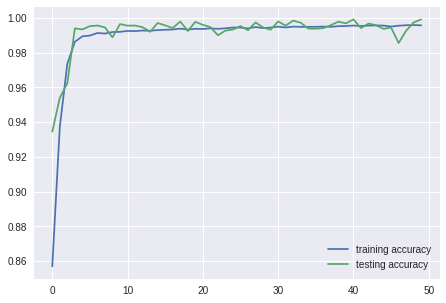

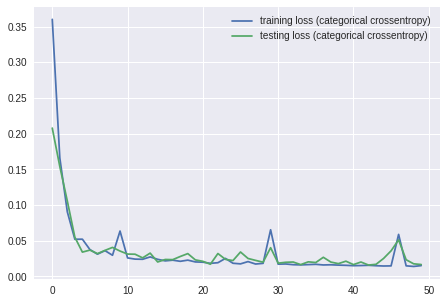

In [ ]:
hist = model.history.history
plot_model_graph(hist)

### Confusion matrix for artificial neural network

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          labels,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if labels is not None:
        tick_marks = np.arange(len(labels))
        plt.xticks(tick_marks, labels, rotation=45)
        plt.yticks(tick_marks, labels)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored